In [2]:
#Import
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from scipy.interpolate import interp1d

In [3]:
#Functions
def preprocess(input_data,label_data,split_ratio=0.2):
    data = pd.read_csv(input_data, sep='\t')
    label = pd.read_csv(label_data, sep='\t')
    X = data.iloc[:, 4:]
    le = LabelEncoder()
    label['Subgroup_encoded'] = le.fit_transform(label['Subgroup'])
    y = np.array(label['Subgroup_encoded'])
    #X_train, X_vali, y_train, y_vali = train_test_split(X.T, y, test_size=0.2, random_state=42)
    return X.T,y

def RFECV_and_plot(data,label,model):
    rfecv = RFECV(estimator=xgb, step=1, cv=StratifiedKFold(5), scoring='accuracy')
    rfecv.fit(data, label)
    print("Optimal number of features : %d" % rfecv.n_features_)
    cv_scores = rfecv.cv_results_['mean_test_score']
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross-validation score (nb of correct classifications)")
    plt.plot(range(1, len(cv_scores) + 1), cv_scores)
    plt.title("RFECV - Optimization of Number of Features")
    plt.show()
    return rfecv
    
def grid_searching(data,label,model):
    param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.001, 0.003, 0.01, 0.03, 0.1, 0.2, 0.3],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 1]}
    grid_search = GridSearchCV(model, param_grid, scoring='accuracy', cv=5)
    grid_search.fit(data, label) 
    best_xgb = grid_search.best_estimator_ 
    return best_xgb

def pred_withCrossValidation(data,label,model,n_folds=5):
    
    cv = StratifiedKFold(n_splits=n_folds)
    y_probs = np.zeros((label.shape[0], len(np.unique(label))))
    
    for train_idx, test_idx in cv.split(x, y):
        model.fit(data.iloc[train_idx,], label[train_idx])
        y_probs[test_idx] = model.predict_proba(data.iloc[test_idx])
        
    y_pred = np.argmax(y_probs, axis=1)
    
    return y_pred,y_probs

def plot_ConfusionMatrix(label,pred):
    cm = confusion_matrix(label, pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

def print_report(label,pred,probs):
    print(classification_report(label, pred))
    print("AUC:",round(roc_auc_score(y, probs, multi_class='ovr'),3))
    

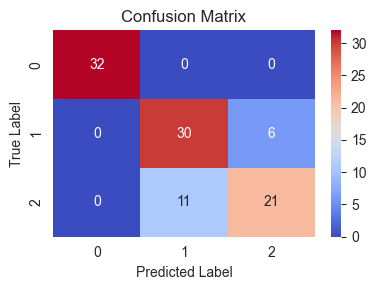

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        32
           1       0.73      0.83      0.78        36
           2       0.78      0.66      0.71        32

    accuracy                           0.83       100
   macro avg       0.84      0.83      0.83       100
weighted avg       0.83      0.83      0.83       100

AUC: 0.937


In [4]:
#Group1:Raw data
x,y = preprocess(input_data='/Users/crystal_zhao/Desktop/B4TM/data/Train_call.txt',
                 label_data='/Users/crystal_zhao/Desktop/B4TM/data/Train_clinical.txt')

xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss') 

best_model = grid_searching(x,y,xgb)

y_pred,y_probs = pred_withCrossValidation(x,y,best_model)

plot_ConfusionMatrix(y,y_pred)
print_report(y,y_pred,y_probs)

Optimal number of features : 41


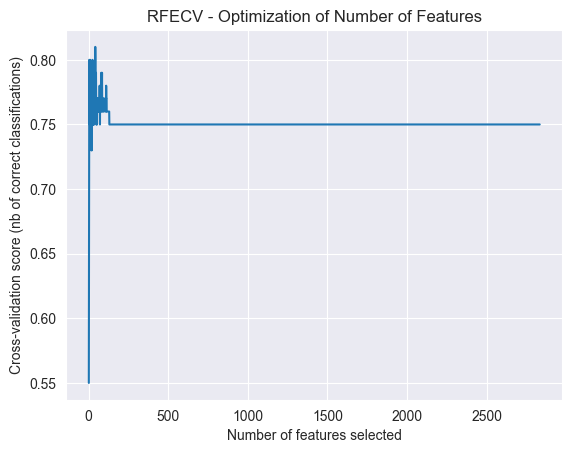

In [9]:
#Group2: REFCV-based features
x,y = preprocess(input_data='/Users/crystal_zhao/Desktop/B4TM/data/Train_call.txt',
                 label_data='/Users/crystal_zhao/Desktop/B4TM/data/Train_clinical.txt')

xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss') 

rfecv = RFECV_and_plot(x,y,xgb)

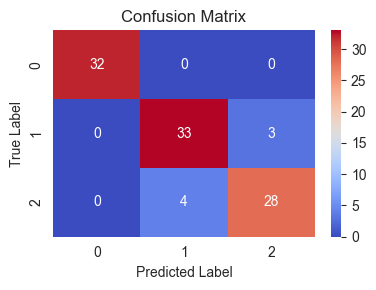

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        32
           1       0.89      0.92      0.90        36
           2       0.90      0.88      0.89        32

    accuracy                           0.93       100
   macro avg       0.93      0.93      0.93       100
weighted avg       0.93      0.93      0.93       100

AUC: 0.984


In [8]:
subset_x = x.iloc[:,rfecv.support_]

best_model = grid_searching(subset_x,y,xgb)

y_pred,y_probs = pred_withCrossValidation(subset_x,y,best_model)

plot_ConfusionMatrix(y,y_pred)
print_report(y,y_pred,y_probs)

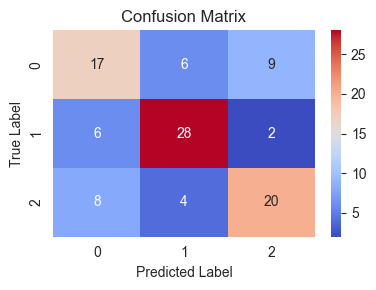

              precision    recall  f1-score   support

           0       0.55      0.53      0.54        32
           1       0.74      0.78      0.76        36
           2       0.65      0.62      0.63        32

    accuracy                           0.65       100
   macro avg       0.64      0.64      0.64       100
weighted avg       0.65      0.65      0.65       100

AUC: 0.803


In [16]:
#Group3: ANOVA-based features #ANOVA code was based on R temporarily
x,y = preprocess(input_data='/Users/crystal_zhao/Desktop/B4TM/data/Train_call_anovaselected.txt',
                 label_data='/Users/crystal_zhao/Desktop/B4TM/data/Train_clinical.txt')

xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss') 

best_model = grid_searching(x,y,xgb)

y_pred,y_probs = pred_withCrossValidation(x,y,best_model)

plot_ConfusionMatrix(y,y_pred)
print_report(y,y_pred,y_probs)
